### imports


In [9]:
from sklearn.metrics import auc
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.utils import normalize
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import cv2
import os
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from dotenv import load_dotenv

In [10]:
a = load_dotenv(".env", override=True)
overwrite = os.getenv("OVERWRITE")
plt.style.use('classic')
#############################################################
# from keras import backend as K
####################################################


### GENERAL SETUP FOR THE DATA

In [11]:
image_directory = 'backflip_images/'
SIZE = 150
# Many ways to handle data, you can use pandas. Here, we are using a list format.
dataset = []
# Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.
label = []


In [12]:
backflip_images = os.listdir(image_directory + 'yes/')
# Remember enumerate method adds a counter and returns the enumerate object
for i, image_name in enumerate(backflip_images):
    if (image_name.split('.')[1] == 'jpg' or image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'yes/' + image_name)
        if image is None:
            continue
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)


Iterate through all images in Uninfected folder, resize to 64 x 64<br>
Then save into the same numpy array 'dataset' but with label 1

In [13]:
uninfected_images = os.listdir(image_directory + 'no/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'jpg' or image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'no/' + image_name)
        if image is None:
            continue
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)


In [14]:
dataset = np.array(dataset)
label = np.array(label)

from keras.utils import to_categorical

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset, label, test_size=0.20, random_state=0)

Without scaling (normalize) the training may not converge.<br>
Normalization is a rescaling of the data from the original range<br>
so that all values are within the range of 0 and 1.

In [16]:
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

Do not do one-hot encoding as it generates a shape of (num, 2)<br>
But the network expects an input of (num, 1) for the last layer for binary classification<br>
y_train = to_categorical(y_train)<br>
y_test = to_categorical(y_test)

############################################

2 conv and pool layers. with some normalization and drops in between.

In [17]:
INPUT_SHAPE = (SIZE, SIZE, 3)  # change to (SIZE, SIZE, 3)

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [19]:
model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [20]:
model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [21]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

In [22]:
model.add(Dense(1))
model.add(Activation('sigmoid'))
# Do not use softmax for binary classification
# Softmax is useful for mutually exclusive classes, either cat or dog but not both.
# Also, softmax outputs all add to 1. So good for multi class problems where each
# class is given a probability and all add to 1. Highest one wins.

Sigmoid outputs probability. Can be used for non-mutually exclusive problems.<br>
But, also good for binary mutually exclusive (cat or not cat).

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',  # also try adam
              metrics=['accuracy'])

In [24]:
print(model.summary())
###############################################################

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

########################################################

In [25]:
history = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    verbose=1,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    shuffle=False
                    )

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7013 - accuracy: 0.5000 - val_loss: 1.0022 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 107ms/step - loss: 0.4920 - accuracy: 0.7500 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 92ms/step - loss: 0.6237 - accuracy: 0.6250 - val_loss: 0.8160 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 95ms/step - loss: 0.4795 - accuracy: 0.7500 - val_loss: 1.1030 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 107ms/step - loss: 0.5381 - accuracy: 0.8750 - val_loss: 0.7058 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 98ms/step - loss: 0.5763 - accuracy: 0.7500 - val_loss: 0.7794 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 93ms/step - loss: 0.7400 - accuracy: 0.6250 - val_loss: 0.6755 - val_accuracy: 0.5000
Epoch 8/10
1/1 [===========

In [26]:
if overwrite == "true":
    model.save('backflips_model.h5')

### If model is already trained
We can load the trained model, so we don't have to train again for 300 epochs!<br>

In [27]:
model = load_model('backflips_model.h5')

For 300 epochs, giving 82.5% accuracy, we can check the accuracy on the test set.

In [28]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 209ms/step - loss: 0.2590 - accuracy: 1.0000
Accuracy =  100.0 %


check the accuracy for a specific image (change n)

In [30]:
n = 1  # Select the index of image to be loaded for testing
img = X_test[n]
# plt.imshow(img)
# Expand dims so the input is (num images, x, y, c)
input_img = np.expand_dims(img, axis=0)
print("If the prediction is less than 0.5, the model predicts a backflip")
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])


If the prediction is less than 0.5, the model predicts a backflip
1/1 [==============================] - 0s 114ms/step
The prediction for this image is:  [[0.74700373]]
The actual label for this image is:  1


# LET'S SEE

### If the prediction is less than .5, the model predicts a FLIP

1/1 [==============================] - 0s 81ms/step
PREDICTION
The program predicts that this image is A FLIP


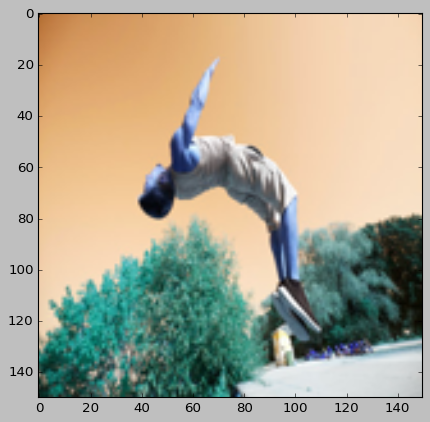

In [33]:
model = load_model('backflips_model.h5')
SIZE = 150

img_path = 'backflip_test.jpg'

image = cv2.imread(img_path)
image = Image.fromarray(image, 'RGB')
image = image.resize((SIZE, SIZE))

plt.imshow(image)

x = np.asarray(image)
x = np.expand_dims(x, axis=0)

x = normalize(x, axis=1)
prediction = model.predict(x)

# print("If the prediction is less than 0.5, the model predicts a backflip")
flip_or_not = "NOT A FLIP"
if prediction < 0.5:
    flip_or_not = "A FLIP"

print("=============================================")
print("PREDICTION")
print("The program predicts that this image is", flip_or_not)
